In [1]:
# NOTE: This is for when the notebook is converted to a python script
# NOTE: Must come before everything else
def get_ipython():
    return type('Dummy', (object,), dict(run_line_magic=lambda *args, **kwargs: None))

%reload_ext autoreload
%autoreload 2
from importlib import reload

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 12})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.rc('figure', figsize=[8, 4])
plt.rc('axes', grid=True)
plt.rcParams.update({'grid.alpha': 0.25})


In [103]:
import kalepy as kale

reload(kale.kde)
reload(kale.kernels)
reload(kale.utils)
reload(kale.plot)
reload(kale)

<module 'kalepy' from '/Users/lzkelley/Programs/kalepy/kalepy/__init__.py'>

# demo

## Basic Usage

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import kalepy as kale

from kalepy.plot import nbshow

Generate some random data, and its corresponding distribution function

In [4]:
NUM = int(1e4)
np.random.seed(12345)
_d1 = np.random.normal(4.0, 1.0, NUM)
_d2 = np.random.lognormal(0, 0.5, size=NUM)
data = np.concatenate([_d1, _d2])

xx = np.linspace(0.0, 7.0, 100)[1:]
yy = 0.5*np.exp(-(xx - 4.0)**2/2) / np.sqrt(2*np.pi)
yy += 0.5 * np.exp(-np.log(xx)**2/(2*0.5**2)) / (0.5*xx*np.sqrt(2*np.pi))

### Plotting Smooth Distributions

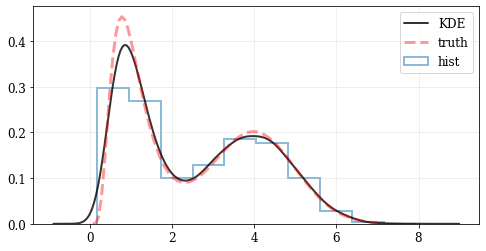

In [5]:
# Reconstruct the probability-density based on the given data points.
# If `points` aren't provided then `kalepy` automatically generates them
points, density = kale.density(data, probability=True)

# Plot the PDF
plt.plot(points, density, 'k-', lw=2.0, alpha=0.8, label='KDE')

# Plot the "true" PDF
plt.plot(xx, yy, 'r--', alpha=0.4, lw=3.0, label='truth')

# Plot the standard, histogram density estimate
plt.hist(data, density=True, histtype='step', lw=2.0, alpha=0.5, label='hist')

plt.legend()
nbshow()

### Constructing statistically similar values

Draw a new sample of data-points from the KDE PDF

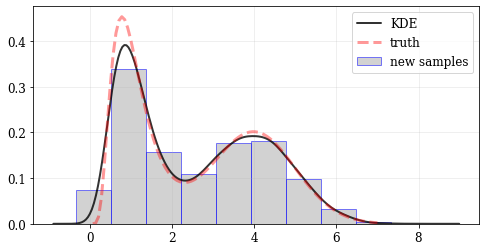

In [6]:
# Draw new samples from the KDE reconstructed PDF
samples = kale.resample(data)

# Plot new samples
plt.hist(samples, density=True, alpha=0.5, label='new samples', color='0.65', edgecolor='b')


# Plot the KDE reconstructed PDF
plt.plot(points, density, 'k-', lw=2.0, alpha=0.8, label='KDE')
# Plot the "true" PDF
plt.plot(xx, yy, 'r--', alpha=0.4, lw=3.0, label='truth')

plt.legend()
nbshow()

## Multivariate Distributions

/Users/lzkelley/Programs/kalepy/kalepy/utils.py:1082: RuntimeWarning: covariance is not positive-semidefinite.
  [+0.2, -0.5, +1.0]


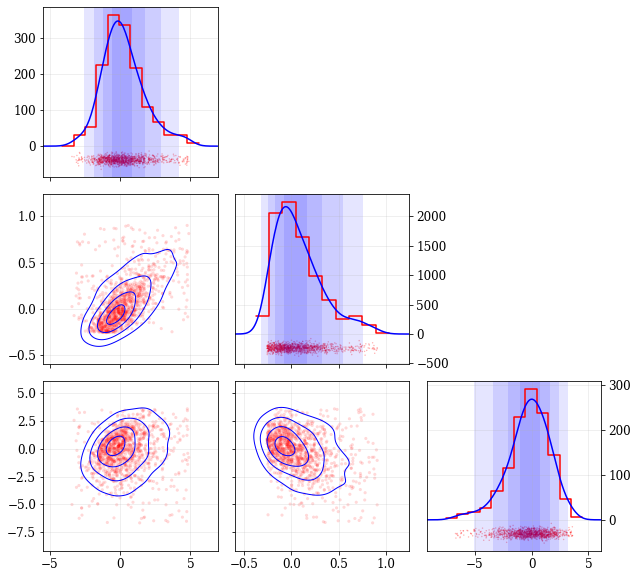

In [109]:
# Load some random-ish data
data = kale.utils._random_data_3d_01()

# Construct a KDE
kde = kale.KDE(data)

import kalepy.plot

# Build a corner plot using the `kalepy` plotting submodule
corner = kale.plot.Corner(kde, figsize=[10, 10])

# Data points: red scatter and histograms
corner.plot_data(color='red', scatter=dict(s=10, alpha=0.15))

# KDE reconstructed density-distribution: blue contours and curves
corner.plot_kde(color='blue')


plt.show()

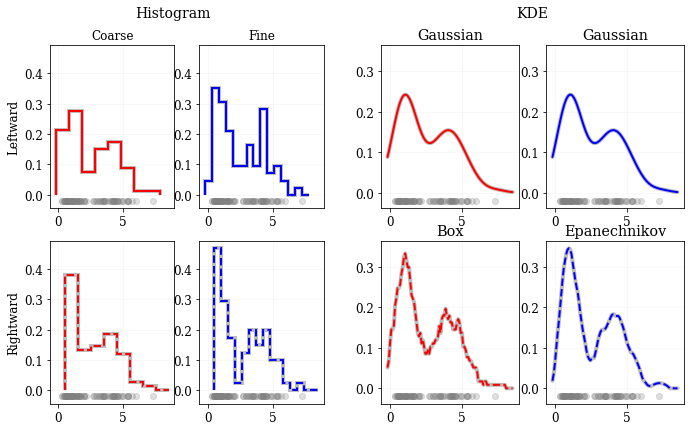

In [110]:
# Setup Figure and Axes
# --------------------------------------
fig = plt.figure(figsize=[10, 6])

# ---- Left Axes
gsl = mpl.gridspec.GridSpec(2, 2)
gsl.update(left=0.08, right=0.46, wspace=0.2, hspace=0.2, top=0.9, bottom=0.07)
axes_ll = np.empty([2, 2], dtype=object)
ax_ref = None
for (ii, jj), ax in np.ndenumerate(axes_ll):
    kw = dict(sharex=ax_ref, sharey=ax_ref) if ax_ref is not None else {}
    ax = plt.subplot(gsl[ii, jj], **kw)
    ax.grid(alpha=0.1)
    axes_ll[ii, jj] = ax
    ax_ref = ax

fig.text(0.25, 0.99, "Histogram", horizontalalignment='center', verticalalignment='top', size=14)
axes_ll[0, 0].set_ylabel('Leftward', size=12)
axes_ll[0, 0].set_title('Coarse', size=12)
axes_ll[0, 1].set_title('Fine', size=12)
axes_ll[1, 0].set_ylabel('Rightward', size=12)

# ---- Right Axes
gsr = mpl.gridspec.GridSpec(2, 2)
gsr.update(left=0.54, right=0.96, wspace=0.2, hspace=0.2, top=0.9, bottom=0.07)
axes_rr = np.empty([2, 2], dtype=object)
ax_ref = None
for (ii, jj), ax in np.ndenumerate(axes_ll):
    kw = dict(sharex=ax_ref, sharey=ax_ref) if ax_ref is not None else {}
    ax = plt.subplot(gsr[ii, jj], **kw)
    ax.grid(alpha=0.1)
    axes_rr[ii, jj] = ax
    ax_ref = ax

fig.text(0.75, 0.99, "KDE", horizontalalignment='center', verticalalignment='top', size=14)

colors = ['r', 'b', 'r', 'b']
lines = ['-', '-', '--', '--']
    

# Create (semi-)Random Data
# --------------------------------------
NUM = 80
np.random.seed(12345)
a1 = np.random.normal(4.0, 1.0, NUM//2)
a2 = np.random.lognormal(0, 0.5, size=(NUM - a1.size))
data = np.concatenate([a1, a2])



# Plot Histograms
# ---------------------------------
bg = dict(color='0.25', lw=4.0, alpha=0.35)

starts = [-0.2, -0.2, 0.5, 0.5]
numbers = [9, 16, 9, 16]

for ii, ax in enumerate(axes_ll.flatten()):
    edges = np.linspace(starts[ii], starts[ii]+8.0, numbers[ii])

    ax.hist(data, bins=edges, histtype='step', density=True, **bg)
    ax.hist(data, bins=edges, color=colors[ii], density=True, ls=lines[ii],
            histtype='step', lw=2.0)
    
    ax.plot(data, -0.02*np.ones_like(data), 'o', color='0.5', alpha=0.25, lw=0.5)

    
    
# Plot KDEs
# ---------------------------------

# bandwidths = ['scott', 0.3, 'scott', 0.3]
kernels = ['Gaussian', 'Gaussian', 'Box', 'Epanechnikov']
# kernels = ['Gaussian', 'Parabola', 'Box', 'Triweight']

bandwidths = [None] * len(kernels)
grid = np.linspace(-0.2, 8.5, 100)

for ii, ax in enumerate(axes_rr.flatten()):
    kde = kale.KDE(data, kernel=kernels[ii], bandwidth=bandwidths[ii])
    ax.set_title(kernels[ii])
    pdf = kde.pdf(grid)
    ax.plot(grid, pdf, **bg)
    ax.plot(grid, pdf, color=colors[ii], ls=lines[ii], lw=2.0)

    ax.plot(data, -0.02*np.ones_like(data), 'o', color='0.5', alpha=0.25, lw=0.5)
        
nbshow()